# Getting started with PRISMO

PRISMO is a framework for factor analysis of multimodal data, with a focus on single-cell omics, representing an observed data matrix $\mat{Y}$ as a product of a low-rank factor matrix $\mat{Z}$ and a low-rank weight matrix $\mat{W}$: $\mat{Y} \approx \mat{Z} \mat{W}$.
It is essentially a synthesis of MOFA{cite:p}`pmid29925568,pmid32393329`, MEFISTO{cite:p}`pmid35027765`, MuVI{cite:p}`pmlr-v206-qoku23a`, nonnegative matrix factorization, and NSF{cite:p}`pmid36587187`.
It natively supports [MuData](https://mudata.readthedocs.io) and [AnnData](https://anndata.readthedocs.io) objects, integrating into the wider [scverse](https://scverse.org) ecosystem.

For this notebook, we will use the [pbmc3k dataset by 10x Genomics](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-3-k-1-standard-2-0-0), conveniently packaged in the `mudatasets` package.
The dataset contains 10 000 single cells profiled with the 10x multiome assay, capturing gene expression (scRNAseq) and chromatin accessibility (scATACseq).

In [1]:
import mudatasets as mds
import muon as mu
import scanpy as sc
import prismo as pr

import plotnine
plotnine.options.set_option("limitsize", False)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



True

In [2]:
mdata = mds.load("pbmc3k_multiome")

■ File filtered_feature_bc_matrix.h5 from pbmc3k_multiome has been found at /home/kats/mudatasets/pbmc3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ Loading filtered_feature_bc_matrix.h5...


/data/ilia/envs/famo/lib/python3.11/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
/data/ilia/envs/famo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/ilia/envs/famo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /home/kats/mudatasets/pbmc3k_multiome/filtered_feature_bc_matrix.h5


/data/ilia/envs/famo/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/data/ilia/envs/famo/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
/data/ilia/envs/famo/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


In [3]:
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2711 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	2711 x 98319
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

## Preprocessing

We first perform the basic preprocessing steps outlined in the [muon tutorial](inv:muon-tutorials#/single-cell-rna-atac/pbmc10k/1-gene-expression-processing.ipynb) to remove undetected genes and poor-quality cells.

In [4]:
rna = mdata["rna"]
rna.var['mt'] = rna.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

atac = mdata.mod['atac']
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

We further normalize the data and subselect highly variable genes that will be used in the analysis.

In [5]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

mu.atac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)
mu.pp.filter_var(atac, atac.var_names[atac.var.highly_variable])

In [6]:
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2636 x 21256
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	2450 x 20985
      obs:	'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

## Fitting a model

Creating a [PRISMO](#prismo.PRISMO) object automatically fits the model using the specified parameters.
A basic understanding of the [model](#modeldescription) is required to correctly set the parameters for a given dataset.

The main deviation from the PRISMO defaults that we will make for the pbmc10k dataset is using a negative binomial likelihood, which is more appropriate for count data than the default Gaussian likelihood.
With default settings, PRISMO will plot the number of observations in each view and group.
This can be turned off by customizing `prismo.DataOptions`.
PRISMO will also automatically save the final model after training which can later be loaded with `prismo.PRISMO.load`.
The name of the saved file can be changed in `prismo.TrainingOptions`.

/data/ilia/envs/famo/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/data/ilia/envs/famo/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


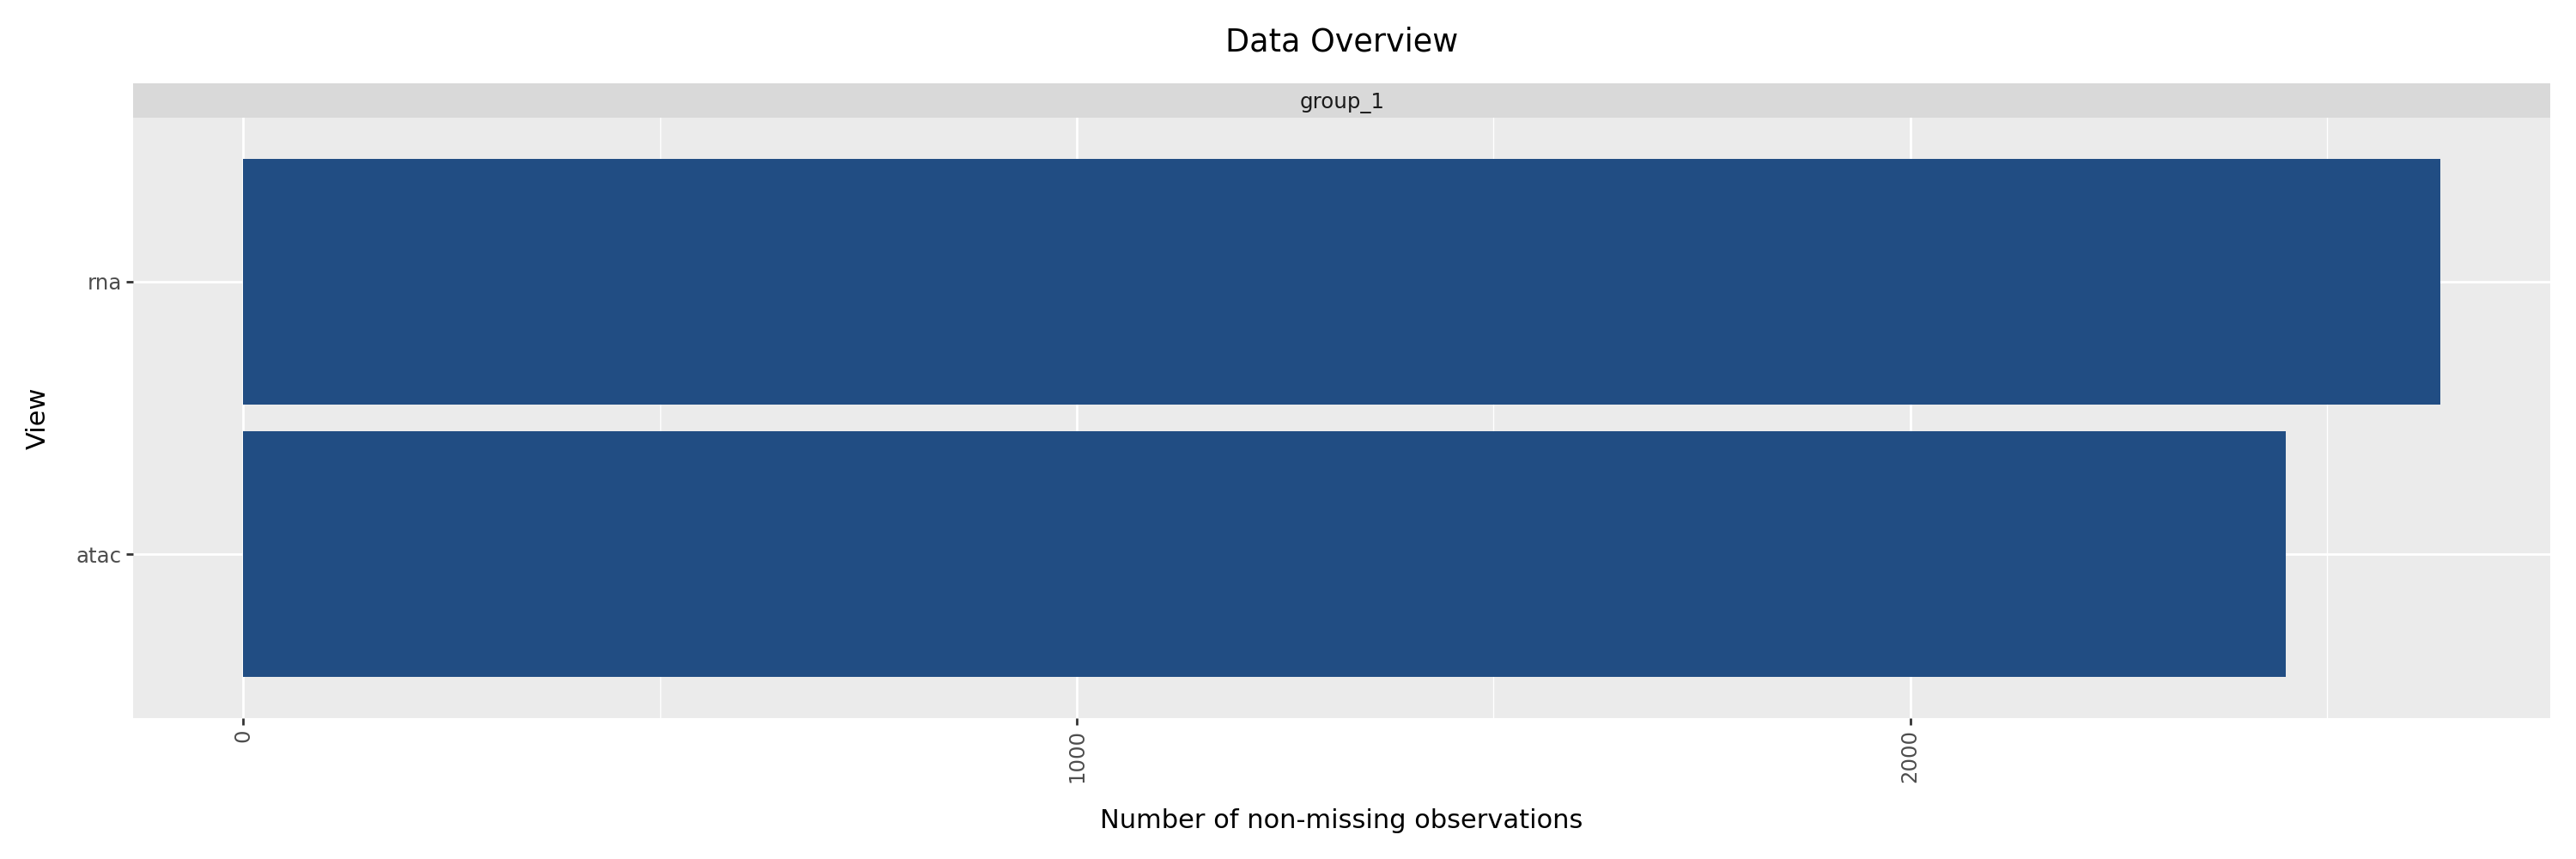

INFO:prismo._core.prismo:Epoch:       0 | Time:       1.35s | Loss:  162389.92
INFO:prismo._core.prismo:Epoch:     100 | Time:      21.46s | Loss:  146749.77
INFO:prismo._core.prismo:Epoch:     200 | Time:      41.55s | Loss:  136444.79
INFO:prismo._core.prismo:Epoch:     300 | Time:      61.45s | Loss:  128805.94
INFO:prismo._core.prismo:Epoch:     400 | Time:      81.27s | Loss:  123114.11
INFO:prismo._core.prismo:Epoch:     500 | Time:     101.11s | Loss:  118763.22
INFO:prismo._core.prismo:Epoch:     600 | Time:     121.00s | Loss:  115688.94
INFO:prismo._core.prismo:Epoch:     700 | Time:     140.79s | Loss:  113773.68
INFO:prismo._core.prismo:Epoch:     800 | Time:     160.57s | Loss:  112198.26
INFO:prismo._core.prismo:Epoch:     900 | Time:     180.34s | Loss:  111350.33
INFO:prismo._core.prismo:Epoch:    1000 | Time:     200.13s | Loss:  110603.73
INFO:prismo._core.prismo:Epoch:    1100 | Time:     219.90s | Loss:  110425.81
INFO:prismo._core.prismo:Epoch:    1200 | Time:     

In [7]:
model = pr.PRISMO(mdata, pr.ModelOptions(n_factors=15, likelihoods="Normal"), pr.TrainingOptions(batch_size=1000, seed=42))

We can plot the loss curve to get an overview of the training process:

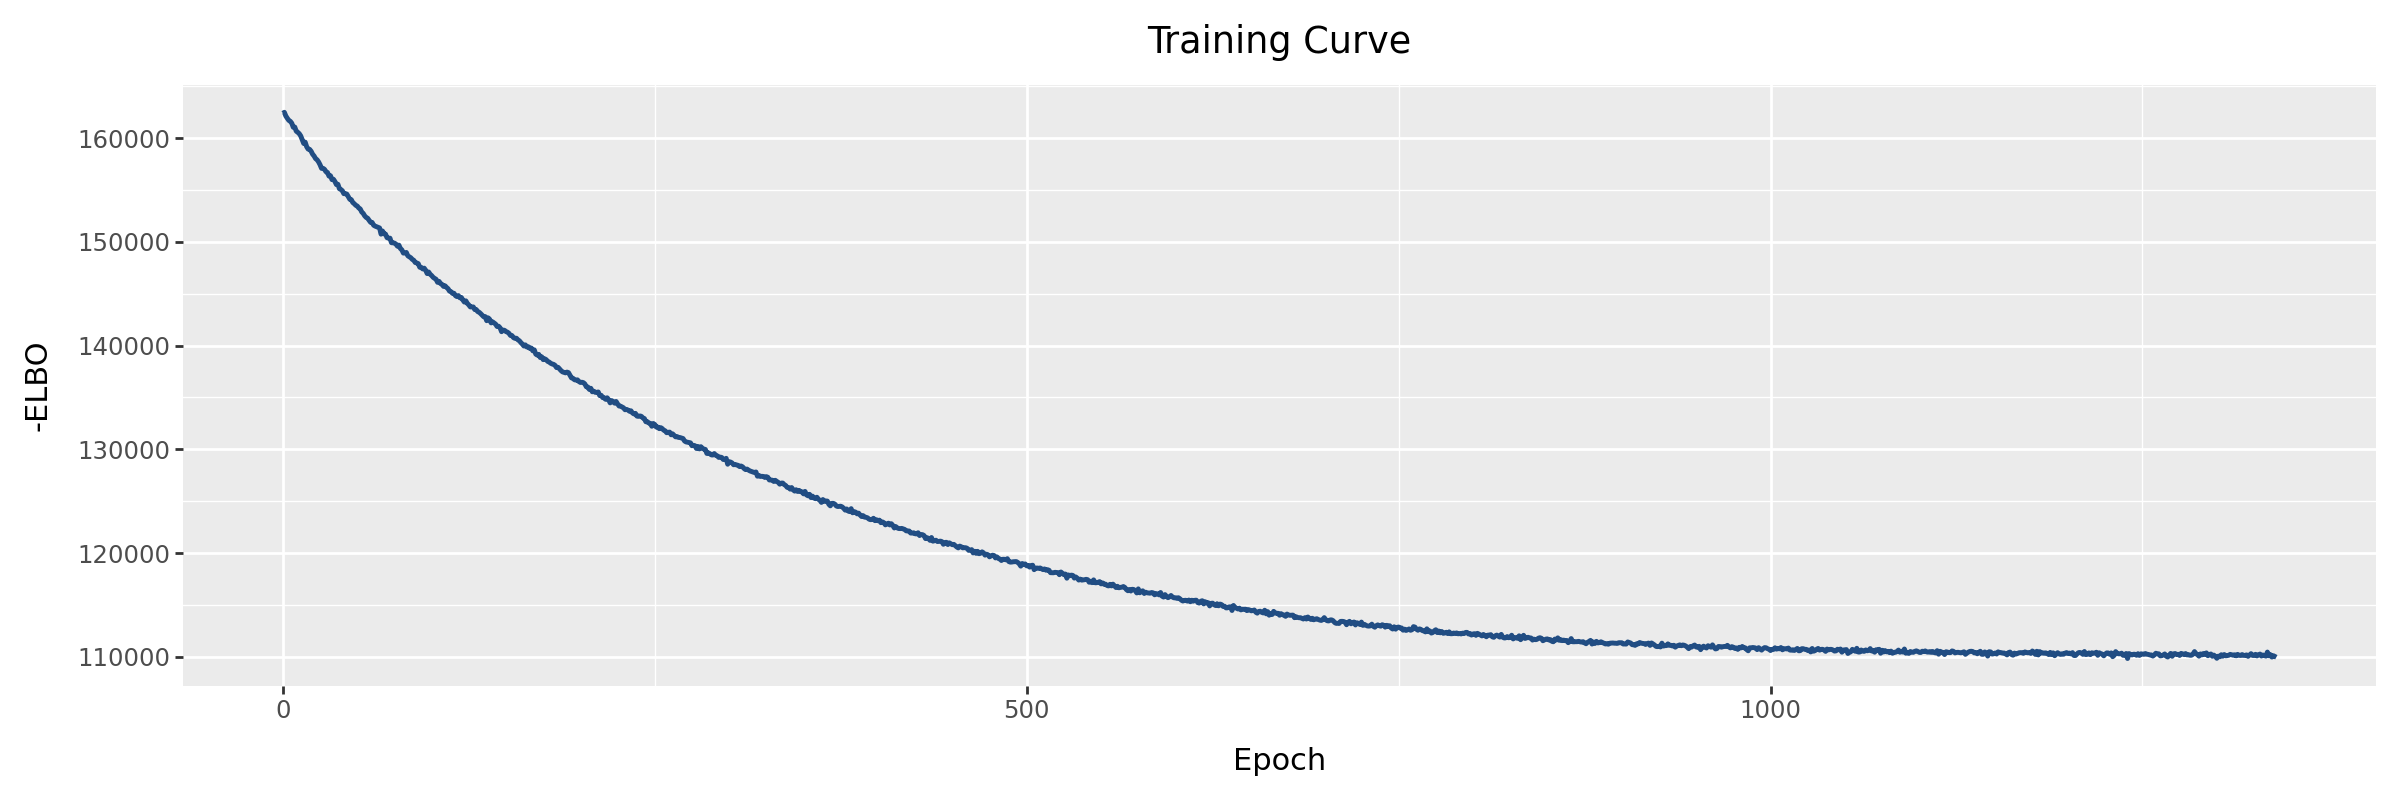

In [8]:
pr.pl.plot_training_curve(model)

## Analysing the model
The trained model can now be analysed to assess its quality and discover relevant biology.
First, we plot the correlations between factors, which should be as low as possible: We want factors to be uncorrelated, as each factor should capture a different aspect of the data.

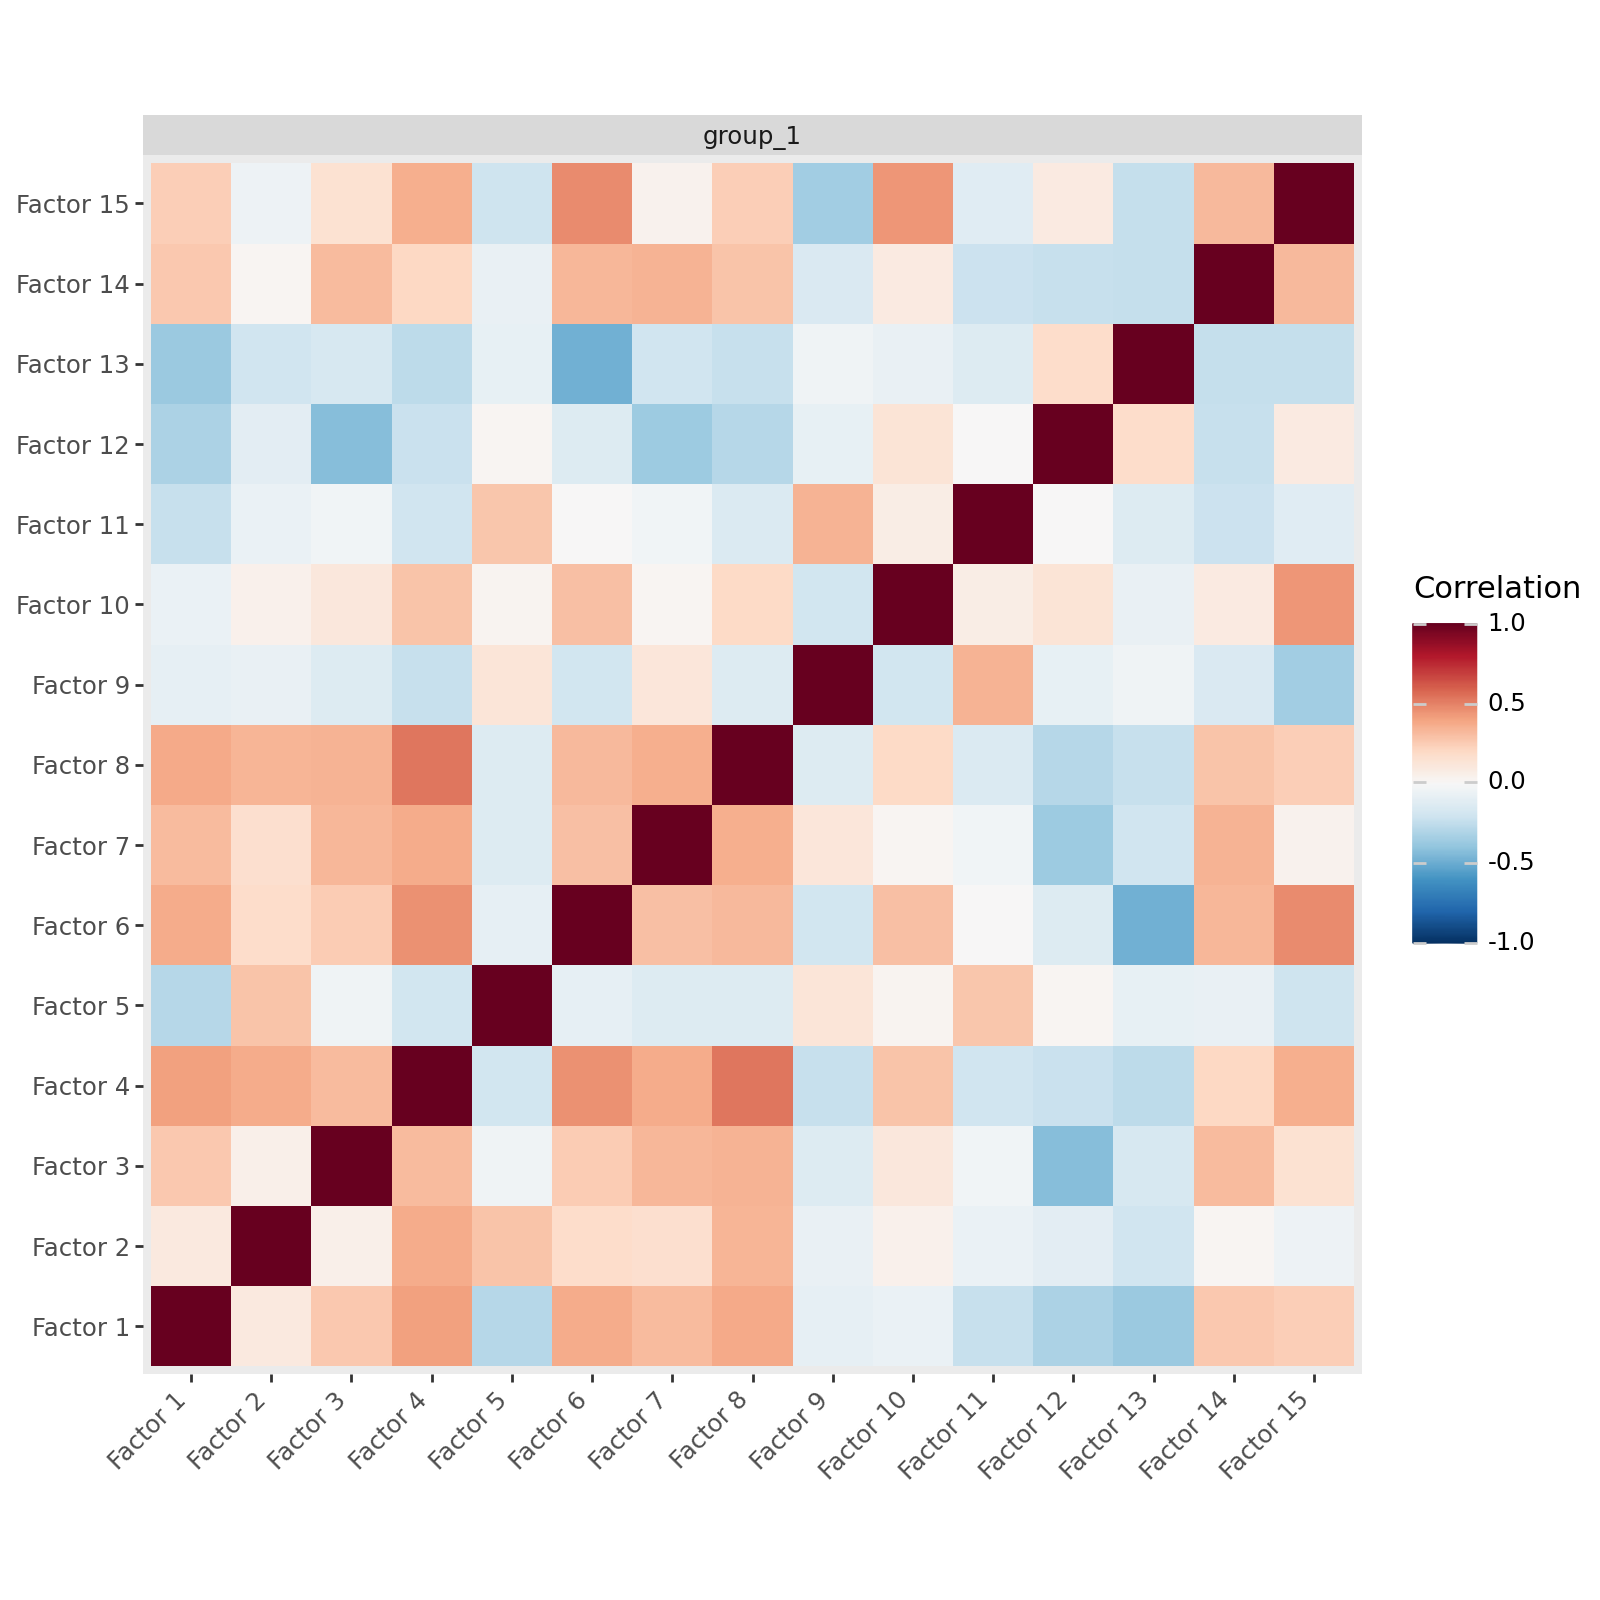

In [9]:
pr.pl.plot_factor_correlation(model)

This is not ideal, but good enough for a first look at the data.
We can now plot the fraction of variance in the data explained by each factor to determine the most important factors.
Note that for non-Normal likelihoods, these values are approximate.

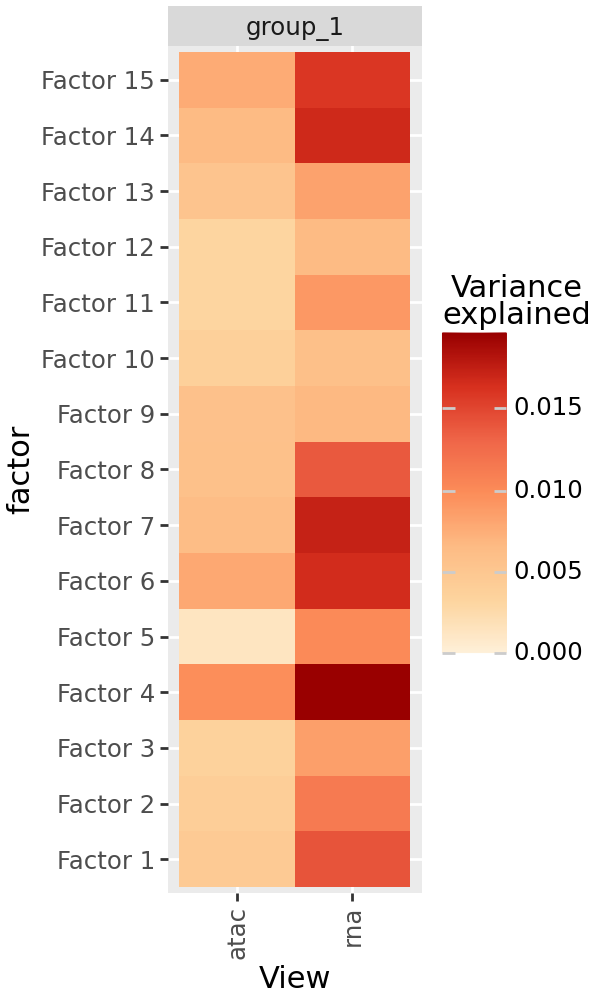

In [10]:
pr.pl.plot_variance_explained(model)

We can plot the most important genes per factor to get an idea of what each factor represents.
This plot aggregates over all views.

/data/ilia/famo/famo/src/prismo/pl/_plotting.py:717: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/ilia/famo/famo/src/prismo/pl/_plotting.py:724: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


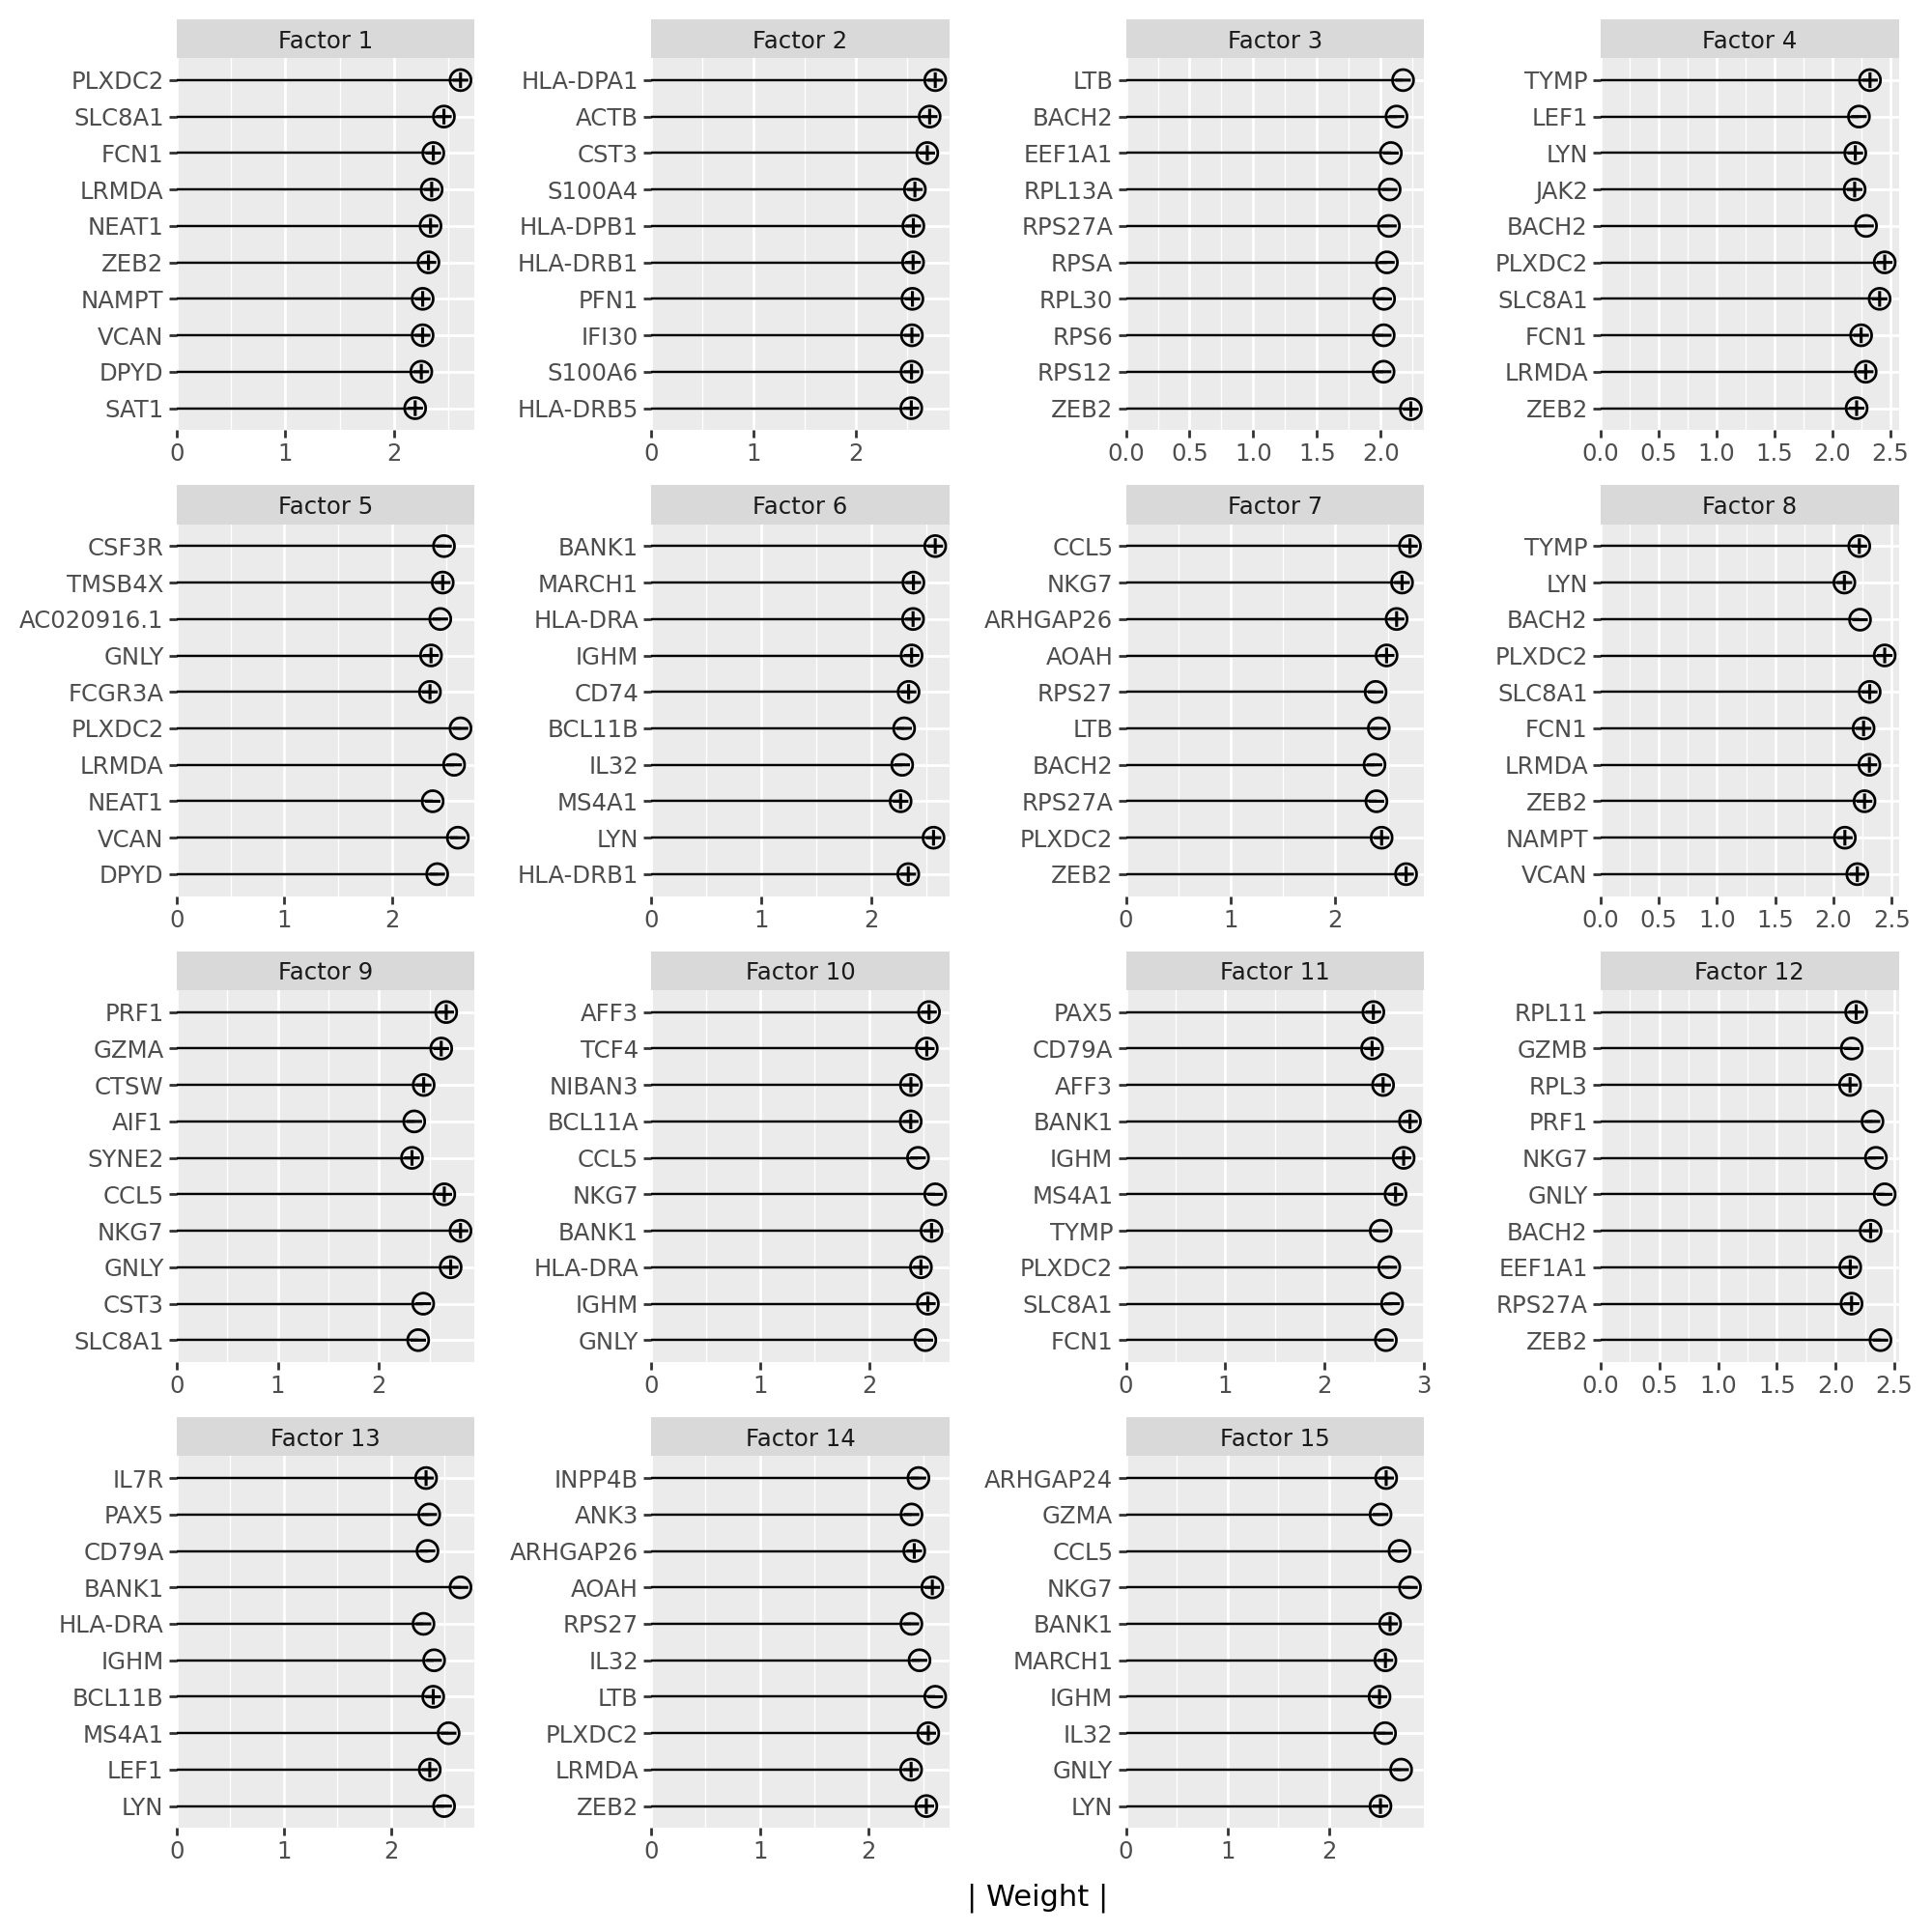

In [11]:
pr.pl.plot_top_weights(model, figsize=(10, 10))

It appears that the most important features are all from the RNA dataset.
We can use a different plotting function to get the top weights individually for each view.

/data/ilia/famo/famo/src/prismo/pl/_plotting.py:770: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


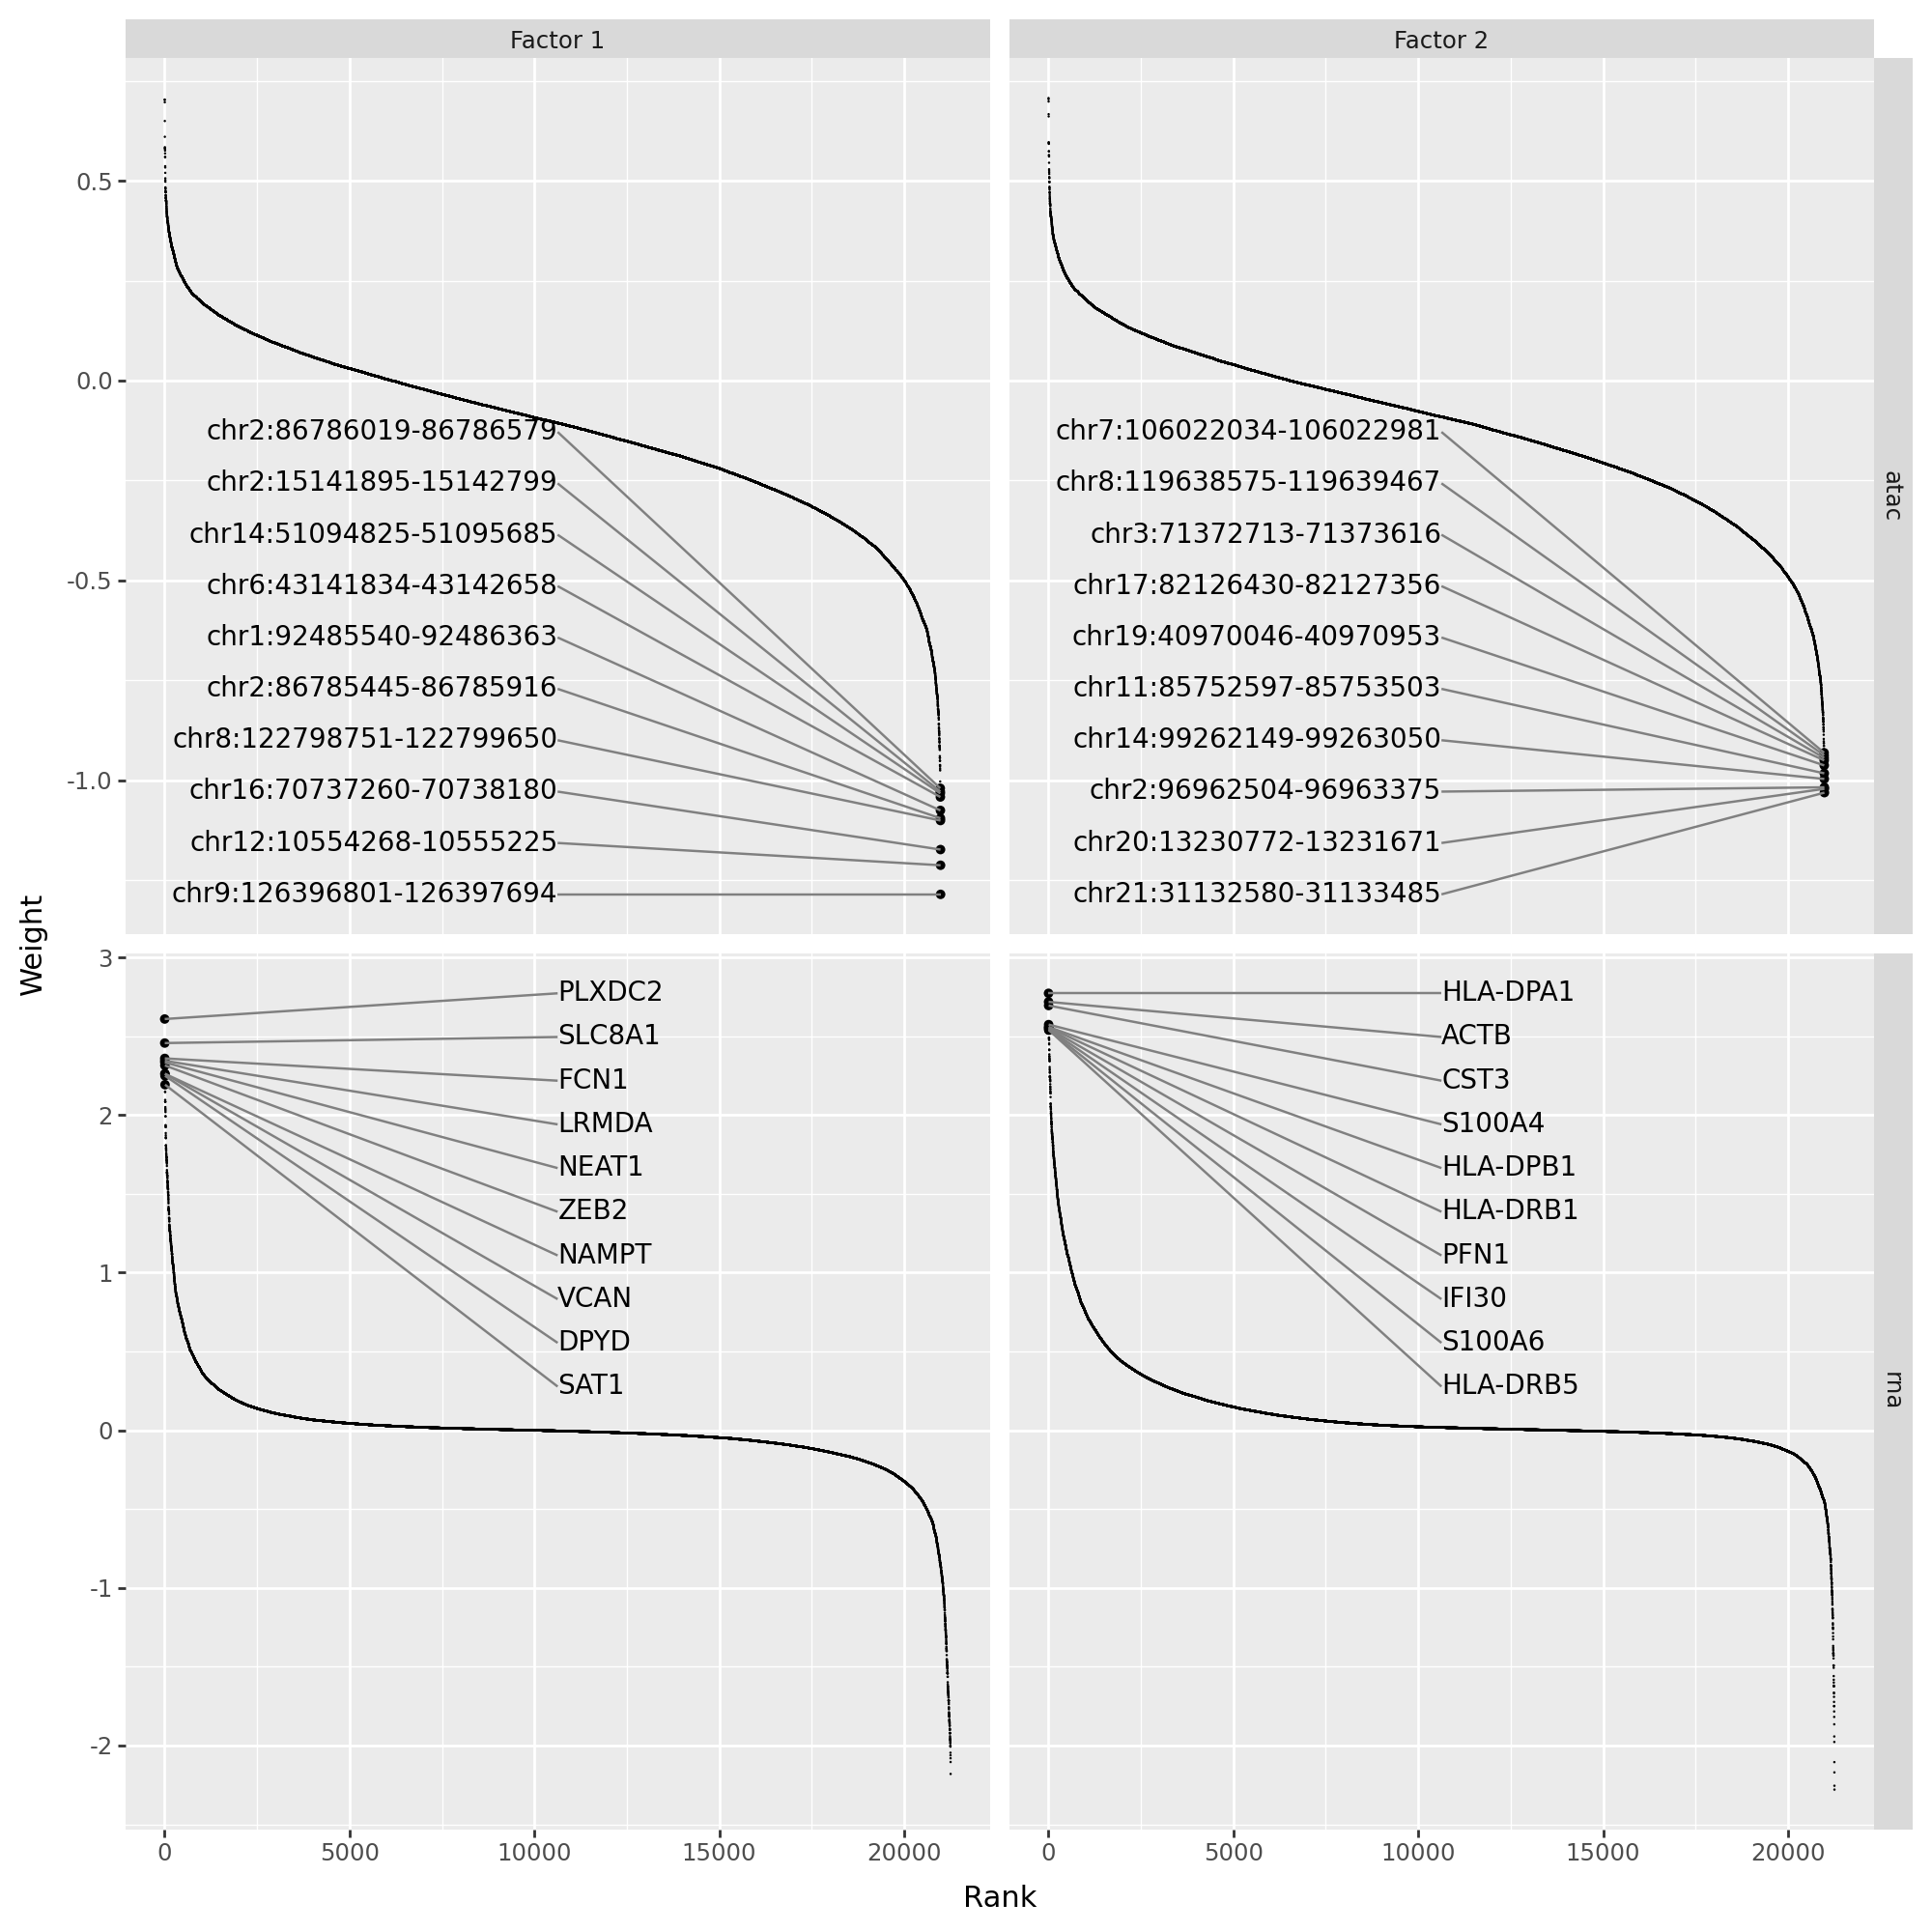

In [12]:
pr.pl.plot_weights(model, factors=(1, 2), figsize=(10, 10))

We can also plot factors agains each other.
This may be useful to define clusters of cells with similar factor values.

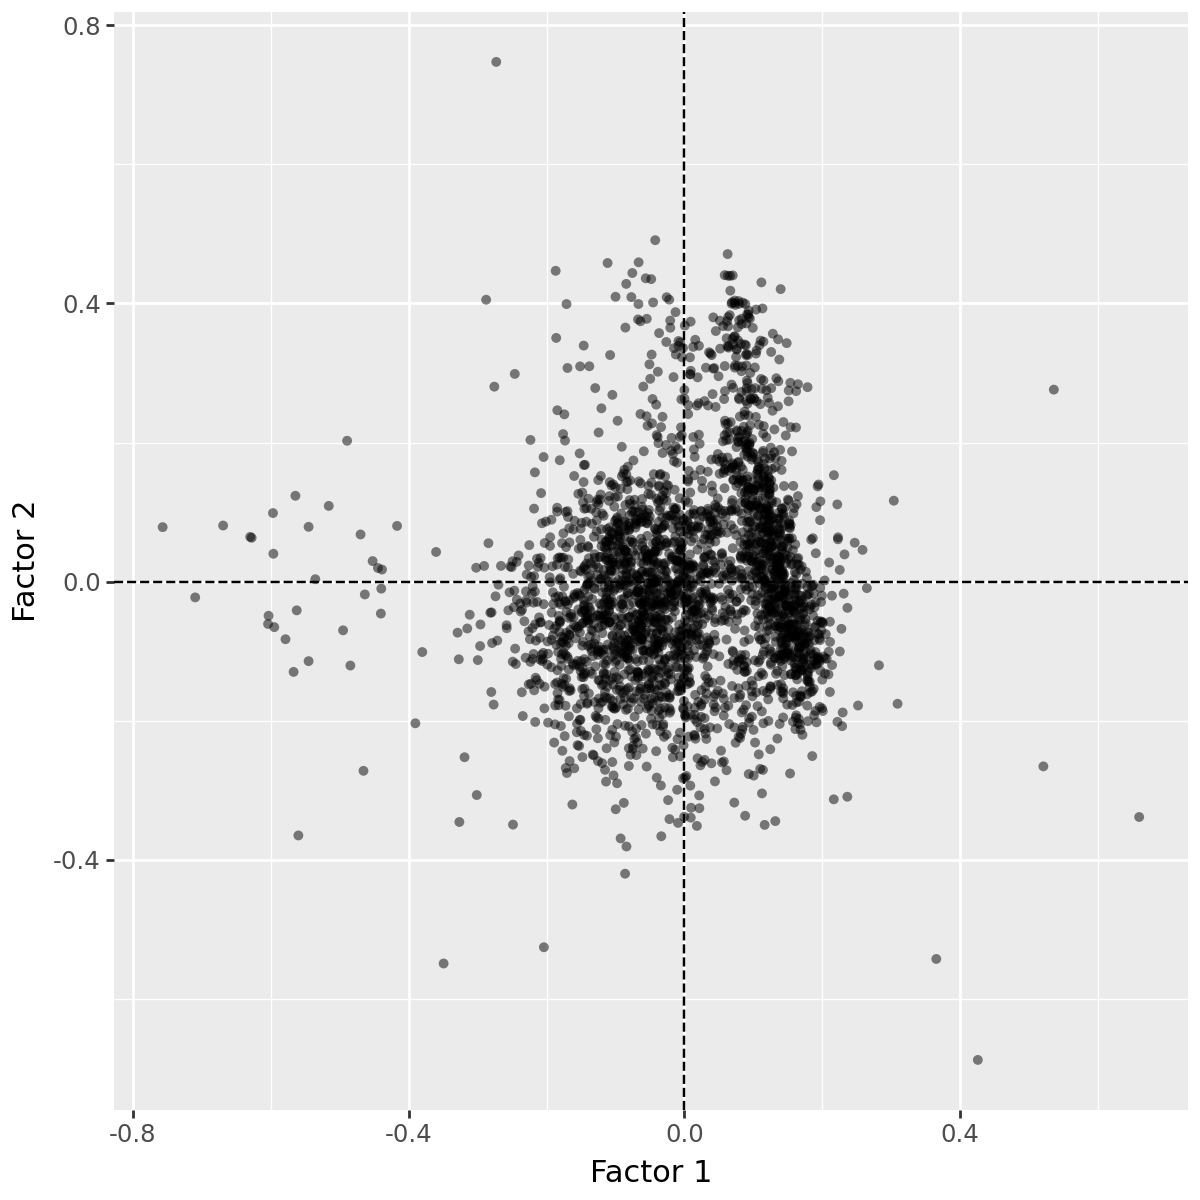

In [13]:
pr.pl.plot_factors_scatter(model, 1, 2, alpha=0.5)

Of course, PRISMO does not and cannot provide all imaginable analysis functions.
It thus provides methods to access the factor and weight values, such that they can be used for manual analysis.

In [14]:
weights = model.get_weights()
factors = model.get_factors()

weights["rna"]

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,AAAS,AACS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
Factor 1,-0.559991,-0.138489,0.131267,-0.052128,0.018328,0.029890,-0.024662,0.000693,-0.024033,0.012489,...,-0.192334,-0.056047,-0.001654,0.016266,-0.150144,0.067609,0.043096,0.173194,0.302906,0.486444
Factor 2,0.264580,-0.120638,-0.015122,0.066646,0.020277,0.033364,0.030009,0.010298,0.289499,-0.030939,...,0.055887,-0.004516,-0.013981,0.011946,0.014971,-0.188352,0.015376,-0.093543,1.465297,0.188473
Factor 3,-0.049683,-0.287450,0.724211,0.247704,0.035574,0.061361,-0.000841,0.014995,-0.169255,0.087215,...,0.061152,0.075596,0.010686,0.019134,0.098915,0.165094,-0.022638,-0.027463,-0.240998,-0.089500
Factor 4,0.082094,-0.023202,-0.552060,-0.194605,0.013997,0.003090,-0.012713,0.012551,-0.019587,-0.114564,...,-0.040801,0.002353,0.033713,-0.040273,0.052705,0.247258,0.033050,0.163917,0.666425,0.392352
Factor 5,-0.038044,-0.014613,0.350651,0.106648,0.055546,0.005621,-0.020884,-0.019855,0.125089,-0.027878,...,0.130248,-0.064164,0.021546,-0.049987,-0.025186,-0.312655,0.014564,-0.142751,0.559596,-0.158856
Factor 6,-0.185701,0.062314,-0.162790,0.034134,0.036395,-0.014848,-0.000864,0.002299,-0.024422,-0.009279,...,0.259577,0.079313,-0.030542,-0.062648,0.072859,0.450983,0.012596,0.054553,0.100907,0.275996
Factor 7,-0.067404,0.081391,1.445829,0.507208,0.014761,0.000358,-0.012760,-0.008259,-0.053549,0.176726,...,0.078928,-0.008233,0.001492,-0.047844,-0.003430,0.372983,-0.035339,0.097655,0.340536,0.430270
Factor 8,0.081830,0.091145,-0.143853,-0.095665,-0.028658,-0.045268,-0.015426,0.020898,0.033438,-0.086691,...,0.012815,-0.010460,-0.001786,0.012222,-0.023163,0.306854,-0.025865,0.129612,0.291874,-0.047839
Factor 9,-0.026986,0.020151,1.616882,0.687581,-0.022868,0.001379,0.011975,0.009633,-0.017089,0.021059,...,0.059681,0.008922,0.003049,0.004474,0.080001,-0.103105,-0.010668,-0.205024,-0.297822,0.082790
Factor 10,0.140011,0.130443,-1.421223,-0.308981,-0.038606,-0.060781,0.012595,-0.010069,0.007343,-0.056865,...,-0.006397,0.121619,-0.002030,0.010591,-0.015009,0.377153,0.024252,0.041389,-0.137443,-0.084636


In [15]:
weights["atac"]

,GL000205.2:67744-68642,GL000219.1:125017-125889,GL000219.1:39937-40840,GL000219.1:44650-45512,GL000219.1:45733-46550,GL000219.1:90065-90960,KI270713.1:29578-30400,KI270721.1:2089-2980,KI270726.1:27153-28037,KI270726.1:41489-42329,...,chrX:9351460-9352236,chrX:9355553-9356419,chrX:93673055-93673972,chrX:9456293-9457196,chrX:9465857-9466651,chrX:9475416-9476190,chrX:9530489-9531388,chrX:9644063-9644975,chrX:96682261-96683167,chrX:9995528-9996416
Factor 1,0.087336,0.029947,-0.160195,-0.217048,-0.049567,-0.119421,-0.188962,-0.192001,-0.178324,-0.209671,...,0.155270,0.282924,0.098378,0.044770,0.081850,0.189496,0.135744,0.039650,0.190391,0.217343
Factor 2,0.306393,-0.015659,0.091057,0.017305,0.173783,0.058664,0.001036,-0.008577,0.036465,-0.048161,...,-0.225497,-0.130970,-0.237055,-0.200696,-0.187264,-0.032444,-0.078471,0.101210,-0.193328,-0.082829
Factor 3,-0.287115,0.188617,-0.135978,-0.010401,-0.053836,-0.281175,-0.071996,0.013441,-0.089289,-0.014258,...,-0.050538,0.039084,0.081636,-0.036768,-0.045013,0.177784,-0.156839,-0.420277,-0.021515,-0.001884
Factor 4,-0.052060,-0.168768,-0.096677,0.019179,-0.233397,0.052612,-0.074085,-0.005140,-0.156331,-0.146349,...,0.090860,-0.024697,0.149847,-0.519770,-0.149636,-0.320512,-0.031292,-0.364415,-0.159832,-0.147364
Factor 5,0.453123,0.082888,-0.132021,-0.215836,-0.074234,-0.109128,-0.051985,-0.094026,-0.014298,0.135754,...,0.422551,0.220766,-0.016197,-0.283165,-0.251596,0.432683,-0.009663,0.012558,-0.062914,-0.073835
Factor 6,0.449830,0.081458,0.160676,0.116484,-0.034018,-0.059190,-0.015016,0.216356,0.113811,-0.201342,...,0.030065,-0.116361,-0.146777,-0.342655,-0.238059,-0.046262,0.044279,-0.189576,0.027138,-0.060318
Factor 7,-0.129250,-0.172826,0.255129,0.099179,0.931458,0.224703,-0.029831,-0.069791,0.011993,-0.156119,...,0.451489,0.099275,-0.085774,-0.211164,0.012705,0.160535,0.039545,0.041277,-0.252123,-0.133177
Factor 8,-0.041377,0.101141,-0.226051,-0.125725,-0.336298,0.000600,-0.215820,-0.083890,-0.156217,0.160742,...,0.063032,0.090715,-0.388719,-0.147639,0.038166,0.052893,-0.124336,0.094900,0.005162,-0.113095
Factor 9,0.047375,-0.014294,0.341860,0.030135,0.297417,0.278396,0.021014,0.118536,0.018430,0.041022,...,0.836308,0.256546,-0.033260,-0.357100,-0.124650,0.178121,-0.160015,0.105904,-0.108953,-0.195509
Factor 10,0.267265,-0.093646,0.039197,-0.215249,-0.446404,0.021657,-0.005131,-0.180956,-0.152763,-0.053241,...,-0.475337,-0.240569,-0.290965,-0.162689,-0.193579,-0.267029,-0.196303,0.183506,-0.046589,-0.220569


In [16]:
factors["group_1"]

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
AAACAGCCAAATATCC-1,0.040700,0.129081,0.000774,-0.120673,0.227587,-0.179023,0.010007,0.050717,0.407601,-0.025567,0.070986,-0.404699,-0.119199,0.268657,-0.315534
AAACAGCCAGGAACTG-1,0.045258,0.251270,-0.006181,0.237594,0.062152,0.109903,0.106248,0.088040,-0.143285,0.035835,-0.106697,-0.030979,-0.029171,0.119728,0.073514
AAACAGCCAGGCTTCG-1,0.164384,-0.131877,0.079311,0.119208,-0.239326,0.115002,0.146105,0.164448,-0.019042,0.073915,-0.020893,-0.076011,-0.085149,0.212383,0.156314
AAACCAACACCTGCTC-1,-0.033217,-0.058753,-0.047171,0.022530,0.127231,0.136844,-0.210852,-0.075118,0.048995,0.116606,0.364793,0.098858,-0.237160,-0.046632,0.237541
AAACCAACAGATTCAT-1,-0.139304,-0.021100,0.126638,-0.239488,0.227723,-0.062276,0.343506,-0.047162,0.325204,-0.345986,0.028707,-0.170970,-0.180927,-0.091659,-0.125809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATTAGCCA-1,-0.166563,-0.257949,0.085246,-0.173940,-0.038265,-0.247429,-0.296863,0.006989,-0.087998,-0.079005,-0.044545,0.031412,-0.102375,-0.015220,0.033764
TTTGTGGCATTGCGAC-1,-0.061528,0.107920,0.076837,-0.099799,0.324863,-0.180939,-0.013832,0.197921,0.335156,-0.185035,0.044710,-0.265712,-0.099464,0.127410,-0.147185
TTTGTGTTCCGCCTAT-1,0.058646,-0.181290,-0.016671,-0.028391,-0.359459,-0.011785,-0.072229,-0.194661,0.070554,0.008024,0.171559,-0.066397,0.106078,-0.050813,-0.064970
TTTGTGTTCCGTGACA-1,0.111760,0.018413,0.143791,-0.141105,0.305498,-0.032435,-0.089393,0.108783,0.463222,-0.273411,0.240171,-0.351026,0.002476,0.369838,-0.310666
